# Reto: Modelo basado en deep learning para la discriminación entre gatos y perros 👩🏽‍💻🐶🐱

**Duración:** 2.5 hrs.

**Introducción:**

Han pasado más de dos años desde que se descubrió la vacuna contra los zombis. Ahora un nuevo peligro amenaza el mundo. Algunas razas de perros son inmunes a la vacuna y pueden crear una nueva cepa del virus. La empresa estadounidense Small Pet, una vez que se dio cuenta del problema, dio aviso a todos los países para que estén alerta.

En México, la empresa Ciencia para el futuro se ha propuesto apoyar con la creación de una aplicación para identificar a dichos perros. Por ello, te ha contratado para que crees una App antes de que los perros infecten a su primera víctima con la nueva cepa del virus mortal.

¿Podrás lograrlo antes de que el mundo caiga nuevamente en manos de los zombis?

**Objetivos:**

* Diseñar modelos de redes neuronales profundas (deep learning), enfocándose en la clasificación de imágenes de acuerdo a categorías preestablecidas para resolver problemas con relevancia social, permitiendo generar valor en los diversos sectores.

* Crear modelos de datos Deep Neural Networks (DNN) utilizando PyTorch basado en Python; seleccionando el modelo adecuado y analizando la exactitud del modelo, para cumplir lo mejor posible con los requerimientos de la tarea requerida.

**Instrucciones:**

Continuando con el problema planteado previamente, se ha logrado vacunar a todos los perros, quienes ya no representan un peligro para la humanidad; sin embargo, el virus ha mutado y ahora ha afectado a los gatos. Por ello, tu tarea es implementar un clasificador que permita discriminar entre perros y gatos.

Para lograrlo, descarga el archivo DS_C7SC4_Formato.docx y la base de datos Catsvsdogs.zip y realiza los siguientes pasos:

1. Analiza la base de datos del archivo Catsvsdogs.zip.
2. Crea una nueva libreta de Jupyter en Google Colab y guárdala.
3. Implementa tu modelo y realiza las pruebas que consideres pertinentes.
4. Asegúrate de alcanzar un accuracy mínimo de 70%.
5. Comenta detalladamente tu proceso en la libreta de Jupyter, dejando muy claro cómo se puede ejecutar.
6. Otorga permisos al archivo para que se pueda evaluar.
7. Coloca la URL de tu archivo de Google Colab con permisos de visualización.
8. Sube el formato y el archivo .ipynb a la plataforma.

### Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### Validación de acceso a GPU

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: ', {device})

Using device:  {device(type='cuda')}


Sí se cuenta con acceso a GPU (cuda).

### Base de datos

Se inicia el desarrollo del modelo de ML de aprendizaje supervisado con una base de datos de 4,898 imágenes etiquetadas de perros y gatos de diferentes razas, divididas por clases de la siguiente forma:
* 🐱gatos: 2,403 elementos
* 🐶perros: 2,495 elementos

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/DL_PyTorch/catsvsdogs'

In [4]:
!ls '/content/drive/MyDrive/Colab Notebooks/DL_PyTorch/catsvsdogs'

cats  dogs


### Generación de set de datos: entrenamiento, validación y pruebas

Posteriormente se crean los conjuntos de datos para entrenamiento, validación y pruebas.

Como es una base de datos relativamente pequeña, se decide utilizar un 80% de las imágenes para entrenamiento, 10% para validación y 10% para pruebas.

El tamaño del batch es de 64 (se utiliza un GPU A100).

In [12]:
transform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [13]:
full_dataset = datasets.ImageFolder(path, transform=transform)

In [19]:
TRAIN_SIZE =  int(len(full_dataset) * 0.8)
VAL_SIZE = int(len(full_dataset) * 0.1)
TEST_SIZE = int(len(full_dataset) * 0.1+1)
BATCH_SIZE = 64

In [20]:
len(full_dataset)

4895

In [21]:
training_set, val_set, test_set = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

In [22]:
# Objetos DataLoader
training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

La imagen muestreada representa un: dog


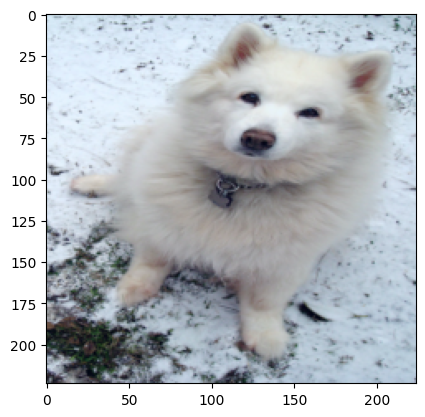

In [26]:
# Validación de las etiquetas
categories = ['cat','dog']
def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.show()

rnd_sample_idx = np.random.randint(TEST_SIZE)
print(f'La imagen muestreada representa un: {categories[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Cálculo de accuracy

Se genera una función para calcular la accuracy o exactitud y utilizarla como métrica del modelo - se refiere a la cantidad de muestras que el modelo ha predicho de forma correcta, dividido entre el total de muestras - esta será suficiente debido a que las clases están equilibradas.

In [27]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device) # utilizando el GPU
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi.squeeze()).sum()
            num_total += pred.size(0)

        return float(num_correct)/num_total

### Implementación de función de entrenamiento

Se genera una función para la iteración del entrenamiento.

In [40]:
def train(model, optimiser, epochs):
    model = model.to(device=device) # utilizando el GPU
    for epoch in range(epochs):
        for (xi, yi) in training_loader:
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi.squeeze())

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
        if epoch % 5 == 0:
            print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

### Implementación de modelo de redes neuronales profundas

Se crea el modelo de redes neutonales profundas con la siguiente estructura:

* 4 capas convolucionales con activación ReLU + BatchNorm + MaxPooling
* Capa densa de salida con 2 neuronas
* Reduce progresivamente la dimensión de la imagen con MaxPooling de 2x2
* Aumenta los filtros conforme va pasando las capas
* Adecuada para clasificación de imágenes con 2 clases

In [38]:
model = nn.Sequential(
    # Capa convolucional 1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    # Capa convolucional 2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    # Capa convolucional 3
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    # Capa convolucional 4
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=True),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    # Aplanar la salida para la capa densa
    nn.Flatten(),

    # Capa totalmente conectada (con 2 clases en la salida)
    nn.Linear(in_features=14*14*128, out_features=2, bias=True)
)

In [35]:
# Resumen del modelo
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         147,584
      BatchNorm2d-14          [-1, 128,

### Ejecución del modelo

Se procede a ejecutar el modelo creado, considerando:
* 50 épocas
* 2 clases
* 0.001 de learning rate

In [41]:
epochs = 50
num_classes = 2
lr = 0.001
optimizer = optim.Adam(params = model.parameters(), lr= lr)
train(model, optimizer, epochs)
acc = accuracy(model, val_loader)

Epoch: 0, costo: 0.6098354458808899, accuracy: 0.6319018404907976,
Epoch: 5, costo: 0.11363985389471054, accuracy: 0.6932515337423313,
Epoch: 10, costo: 0.22253377735614777, accuracy: 0.7648261758691206,
Epoch: 15, costo: 0.0491003692150116, accuracy: 0.7995910020449898,
Epoch: 20, costo: 0.01843845658004284, accuracy: 0.7995910020449898,
Epoch: 25, costo: 0.04321426525712013, accuracy: 0.7566462167689162,
Epoch: 30, costo: 0.0002938186516985297, accuracy: 0.8261758691206544,
Epoch: 35, costo: 0.0001871544518508017, accuracy: 0.8282208588957055,
Epoch: 40, costo: 0.00046350076445378363, accuracy: 0.8261758691206544,
Epoch: 45, costo: 0.6481410264968872, accuracy: 0.7811860940695297,


**Exactitud con los datos de validación**

In [42]:
print(acc)

0.8139059304703476


**Exactitud con los datos de prueba**

In [43]:
acc_test = accuracy(model, test_loader)
print(acc_test)

0.8


**Matriz de confusión**

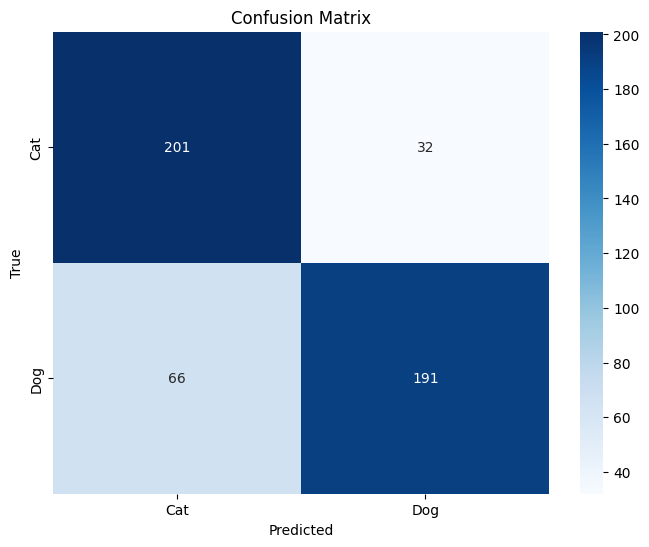

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear un gráfico de calor (heatmap)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    all_preds = []  # Lista para guardar las predicciones
    all_labels = []  # Lista para guardar las etiquetas verdaderas

    # Desactivar el cálculo de gradientes para la evaluación
    with torch.no_grad():
        for xi, yi in test_loader:
            xi, yi = xi.to(device), yi.to(device)
            outputs = model(xi)
            _, preds = torch.max(outputs, 1)  # Obtener la clase predicha (índice de la clase con mayor score)

            all_preds.extend(preds.cpu().numpy())  # Guardar las predicciones
            all_labels.extend(yi.cpu().numpy())  # Guardar las etiquetas verdaderas

    # Calcular la matriz de confusión
    class_names = ['Cat', 'Dog']
    plot_confusion_matrix(all_labels, all_preds, class_names)

# Llamar a la función de evaluación en el conjunto de prueba
evaluate(model, test_loader, device)

### Conclusiones

En este trabajo se desarrolló un modelo de red neuronal profunda para la clasificación de imágenes en dos categorías: gatos y perros. El modelo alcanzó una exactitud del **80%**, cumpliendo con los objetivos planteados. A partir de la matriz de confusión, se observa un buen desempeño en la identificación de ambas clases, con **201 verdaderos positivos** para gatos y **191 verdaderos negativos** para perros, aunque se presentan **32 falsos positivos** y **66 falsos negativos**. Estos resultados indican que el modelo es capaz de discriminar eficientemente entre las clases, aunque podría beneficiarse de ajustes adicionales para reducir los errores de clasificación.